Title (Steve, Eva, Liam, Jacky)

Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question

Data Set information: 
The dataset was collected by Ka​​hraman et al. The weighting system and development of quantitative measurements for the variables was done using Kahramans rule based system which gives quantitative values(ratings) to students' performances in certain academic related parameters. The parameters:


STG: Refers to Study time rating(0-1), the amount time spend studying about Electrical DC Machines.

SCG: Refers to Repetition rating(0-1),  the amount of problems, material the student worked on. For example, worksheets, tutorials.

PEG: Refers to the exam performance rating of the subject(0-1), in this case, the exam performance on Electrical DC Machine course.

STR: Refers to Study time rating of related subjects(0-1), the amount of time students spent studying related topics.

LPR; Refers to exam performance rating in related subjects(0-1), exam performance on related material, or background information.

*UNS(): Refers to student understanding levels; Based on the weighting system Kahramans uses in his rule based system paper, classified  as “Very-low” “Low”, “Middle”, or “High” Understanding of Electrical DC Machines. 

Methods & Results:

describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend

### 1. loading in all the packages for data analysis

In [1]:
install.packages("themis")
install.packages("kknn")
library(kknn)
library(purrr)
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(cowplot)
options(repr.matrix.max.rows = 6)

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ dplyr   1.1.1
✔ tibble  3.2.1     ✔ stringr 1.5.0
✔ tidyr   1.3.0     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──


ERROR: Error in library(cowplot): there is no package called ‘cowplot’


### 2. Reading in the data from the web, and Preparation of Data analysis

#### (A) loading the data
After loading the data, we factorize the variable we want to predict, UNS, by using the function as.factor.

In [2]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

##Loading data
url <- "https://github.com/JackyLinllk/ubc_dsci100_assignment/raw/main/data/Data_User_Modeling_Dataset_full.csv"
knowledge_data<-read_csv(url)|>
    select(STG:UNS)|>
    mutate(UNS = as.factor(UNS))
knowledge_data

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
Rows: 404 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG
lgl (3): ...7, ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.000,0.00,0.00,0.00,very_low
0.08,0.080,0.10,0.24,0.90,High
0.06,0.060,0.05,0.25,0.33,Low
0.10,0.100,0.15,0.65,0.30,Middle
0.08,0.080,0.08,0.98,0.24,Low
0.09,0.150,0.40,0.10,0.66,Middle
0.10,0.100,0.43,0.29,0.56,Middle
0.15,0.020,0.34,0.40,0.01,very_low
0.20,0.140,0.35,0.72,0.25,Low


##### Table 1: Dataset Of Students' Knowledge Status
    This table represents the students' knowledge status about the subject of Electrical DC Machines. 
    For specific meaning of the columns refer back to the intro about the "Data set Information".

    The dataset had been obtained from: 
     Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). 
    User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.

#### (B) NA-values
We then check for NA-values, and realized that the last row restores NA-values across all the variables, so we just simply deleted the last row of the dataset

In [3]:
##Check NA rows
na_row= which(!complete.cases(knowledge_data))
print(na_row)

##Delete the NA row of the data
knowledge_data= knowledge_data[-nrow(knowledge_data),]
knowledge_data

[1] 404


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.000,0.00,0.00,0.00,very_low
0.08,0.080,0.10,0.24,0.90,High
0.06,0.060,0.05,0.25,0.33,Low
0.10,0.100,0.15,0.65,0.30,Middle
0.08,0.080,0.08,0.98,0.24,Low
0.09,0.150,0.40,0.10,0.66,Middle
0.10,0.100,0.43,0.29,0.56,Middle
0.15,0.020,0.34,0.40,0.01,very_low
0.20,0.140,0.35,0.72,0.25,Low


##### Table 2: Dataset Of Students' Knowledge Status with removed NA-Values
 Data set after the NA-Values are removed

#### C) Final prep 
We check the data’s tidiness from "Table 2" by looking into 3 factors, which are: (1) each row is a single observation, (2) Each column is a single variable, (3) Each value is in single cell. 


After checking the data is tidy, we utilize function called
group_by with summarize to find the summary statistics of the number of observations in
each factor level with the corresponding proportion (Table 3).

We realize that under the quantitative variable named UNS, the factor levels
named “very_low” and “Very Low” should be in the same level. Thus, we apply the function
mutate with function fct_recode to merge two factor levels into one

On top of that, we realized the
classifier is class imbalance, which means the proportion for each stratum is not equally
proportional. Thus, we apply the functions called uc_recipe and step_upsample to rebalance
the rare class, namely “Very Low”, by oversampling. Then, we again utilize group_by with
summarize to check each stratum is equally proportional to each other

In [4]:
## Creating the Summary table and checking for Proportion 
class_prop = knowledge_data|>
  group_by(UNS)|>
  summarize(count = n(),
            percentage= count/nrow(knowledge_data))
class_prop


UNS,count,percentage
<fct>,<int>,<dbl>
High,102,0.25310174
Low,129,0.32009926
Middle,122,0.30272953
Very Low,26,0.06451613
very_low,24,0.05955335


##### Table 3: Summary Statistics of The number of Observations Knowledge Levels
    This table represents the summary statistics of the number of observations in
    each factor level with the corresponding proportion.

In [5]:
##Typo in the dataset #very_low and Very Low should be same observation
knowledge_data= knowledge_data|>
  mutate(UNS = fct_recode(UNS, "Very Low" =  "very_low"))

##Balancing the data
ups_recipe= recipe(UNS~. ,data=knowledge_data)|>
  step_upsample(UNS, over_ratio=1, skip=F)|>
  prep()
upsampled_knowledge=bake(ups_recipe, knowledge_data)

##Checking the balance
upsampled_knowledge|>
  group_by(UNS)|>
  summarize(n=n())


UNS,n
<fct>,<int>
High,129
Low,129
Middle,129
Very Low,129


##### Table 5: Summary Statistics of The number of Observations Knowledge Levels After Balancing the Data
    This table represents the summary statistics with upsampleding to Balance the Data

### 3. Spliting the data into 70% properation of training data and testing data

We separated the data using the initial_split function to create 2 subsets, namely training set and testing set.
Inside the initial_split function, we set strata argument to the categorical variable UNS. The
training and testing functions are used to create two different data frames with the
corresponding weight of 70% and 30%.

In [6]:
##Split the data into training set and testing set
knowledge_data_split <- initial_split(upsampled_knowledge, prop = 0.70, strata = UNS)  
knowledge_data_split_train <- training(knowledge_data_split)
knowledge_data_split_test <- testing(knowledge_data_split)

knowledge_data_split_train

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.299,0.700,0.950,0.22,0.66,High
0.320,0.280,0.720,0.89,0.58,High
0.300,0.160,0.890,0.32,0.95,High
0.310,0.820,0.470,0.40,0.99,High
0.470,0.470,0.250,0.96,0.61,High
0.210,0.320,0.250,0.50,0.80,High
0.660,0.360,0.560,0.40,0.83,High
0.770,0.290,0.740,0.82,0.68,High
0.220,0.480,0.470,0.78,0.81,High


##### Table 6: The Training set of Student's Knowledge 
    This table represents the training set we're utilizing to train our models

In [7]:
knowledge_data_split_test

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.280,0.16,0.690,0.33,0.78,High
0.480,0.30,0.150,0.65,0.77,High
0.310,0.82,0.470,0.40,0.99,High
0.870,0.23,0.250,0.85,0.80,High
0.120,0.12,0.750,0.35,0.80,High
0.210,0.78,0.420,0.32,0.84,High
0.300,0.16,0.890,0.32,0.95,High
0.780,0.21,0.680,0.65,0.75,High
0.200,0.45,0.280,0.31,0.78,High


##### Table 7: The Testing set of Student's Knowledge 
    This table represents the testing set we're utilizing to evaluate our models with

 #### 4. Parameter selection: Finding the best K value
 Our next step is to find the best K value which maximizes the accuracy for our model,
where K is the number of neighbors. We will be using cross-validation with validation set of
5 in the training set to find the best possible k value. In other words, we will split our
training data into 5 training sets. 

Firstly, we apply nearest_neighbor, set_engine, and set_mode
functions to create a model specification. Inside the nearest_neighbor function, the argument
weight_func is set to rectangular, which means each k neighbor are equally important. For
the neighbors argument, tune() is telling the framework to find the different parameter values
for K.

Since KNN classification uses Euclidean distance between points, so it is very sensitive
to the different types of scale. Thus, we planned to standardize the variables for all chosen
variables to ensure the predictive algorithms are accurate and unbiased. We managed to
standardize all the variables by using the recipe function with step_center(all_predictors()) and
step_scale(all_predictors()).

For cross-validation, we use vfold_cv function to set the validation set into 5 folds
by using the training set. Finally, we create a tribble with neighbors and use the seq function to
set the K-values to odd numbers (e.g., 1,3,5... 𝑛). The reason why we don’t want even
numbers is because each neighbor is equally weighted; therefore, the even numbers will
cause confusion.

Finally, we put everything into workflow to chain all the steps together to get the
accuracy of different K-values. 


In [8]:

##Finding the k value for best accuracy
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

##Choosing all the variables as predictors, and standardize it
data_recipe <- recipe(UNS ~. , data = knowledge_data_split_train)|>
  step_center(all_predictors())|>
  step_scale(all_predictors())

training_vfold <-  vfold_cv(knowledge_data_split_train, v=5, strata = UNS)

k_value = 101
K <- tibble(neighbors = seq(1,k_value,2))

knn_result <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_tune)|>
  tune_grid(resamples = training_vfold, grid = K) |>
  collect_metrics()|>
  filter(.metric == "accuracy")
knn_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8555556,5,0.023488242,Preprocessor1_Model01
3,accuracy,multiclass,0.8388889,5,0.023895348,Preprocessor1_Model02
5,accuracy,multiclass,0.8000000,5,0.034749989,Preprocessor1_Model03
7,accuracy,multiclass,0.7750000,5,0.032394177,Preprocessor1_Model04
9,accuracy,multiclass,0.7777778,5,0.015835770,Preprocessor1_Model05
11,accuracy,multiclass,0.7638889,5,0.023651926,Preprocessor1_Model06
13,accuracy,multiclass,0.7500000,5,0.030429031,Preprocessor1_Model07
15,accuracy,multiclass,0.7361111,5,0.027428358,Preprocessor1_Model08
17,accuracy,multiclass,0.7361111,5,0.019144512,Preprocessor1_Model09


##### Table 8: Accuracy of different K values  
    This table represents the Accuracy of different K values from 1 to 101, Advancing by 2

#### 5. Visualizing the optimal K-value

We used the ggplot function to create a line graph which
helps to visualize the accuracy trends under corresponding K-values. Surprisingly, when the
K=1, we have the most accurate K-value for the model. Thus, we choose K equals to one as
our optimal K-value.

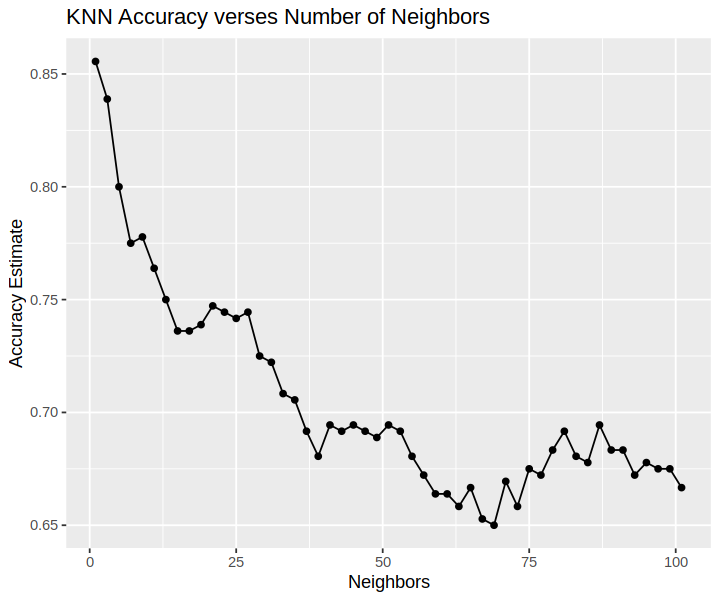

In [9]:
##Scatter plot on the accuracy and number of neighbors
cross_val_plot <- ggplot(knn_result, aes(x=neighbors, y= mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ggtitle(label= "KNN Accuracy verses Number of Neighbors")
cross_val_plot

##### Plot 1: KNN Accuracy verses Number of Neighbors
    This plot represents the Virtualization of "Table 7". Notably, the Highest accuracy came from a K neighbor of 1.

#### 6. Creating the model with the optimal K-value

In [10]:
##Finding confusion matrix of model using testing set
knn_best_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")


knn_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_best_tune)|>
  fit(knowledge_data_split_train)


#### 7. Predicting the model on the testing data set, and evaluating the model

After we have our confusion matrix, we are planning to calculate the corresponding
accuracy, precision, and recall for all the diagonal entries (where 𝑖 = 𝑗). Since the confusion
matrix is in the list, we first convert it into matrix form.
For the accuracy calculation, we apply the formula: 𝐴𝑐𝑐𝑢𝑟𝑎𝑐𝑦 = 𝑁𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛
𝑇𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠 ,
where the number of correct predictions are the diagonal entries, and the total number of
predictions are the sum of all entries. In R, we can simply calculate the accuracy by:
sum(diag(matrix))/sum(matrix)
For precision calculation, the formula is: 𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠
𝑡𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠 ,
where the number of correct positive predictions corresponds to the specific diagonal value,
and the total number of positive predictions are the sum of rows in that diagonal value.
Thus, we will be calculating all the diagonal entries one by one. For example,
𝐶𝑚,𝑚 = 𝑚𝑎𝑡𝑟𝑖𝑥[𝑚,𝑚]/(𝑠𝑢𝑚(𝑚𝑎𝑡𝑟𝑖𝑥[𝑚,]))
Then we take the average of all diagonal entries to find the average precision for our model.
For recall calculation, the formula is: 𝑅𝑒𝑐𝑎𝑙𝑙 = 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠
𝑇𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑜𝑠𝑖𝑡𝑖𝑣𝑒 𝑡𝑒𝑠𝑡 𝑠𝑒𝑡 𝑜𝑏𝑠𝑒𝑟𝑣𝑎𝑡𝑖𝑜𝑛𝑠, where
the number of correct positive predictions are the specific diagonal value, and the total
number of positive test set observations are the sum of the column in that diagonal value.
For example,
𝐶𝑚,𝑚 = 𝑚𝑎𝑡𝑟𝑖𝑥[𝑚,𝑚]/(𝑠𝑢𝑚(𝑚𝑎𝑡𝑟𝑖𝑥[,𝑚]))
Similarly, we will take the average of all diagonal entries to find the average recall for our
model.

In [11]:
## Predicting the UNS of testing data set
knowledge_predictions= knn_fit|>
  predict(knowledge_data_split_test)|>
  bind_cols(knowledge_data_split_test)
knowledge_predictions


.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
High,0.280,0.16,0.690,0.33,0.78,High
High,0.480,0.30,0.150,0.65,0.77,High
High,0.310,0.82,0.470,0.40,0.99,High
High,0.870,0.23,0.250,0.85,0.80,High
High,0.120,0.12,0.750,0.35,0.80,High
High,0.210,0.78,0.420,0.32,0.84,High
High,0.300,0.16,0.890,0.32,0.95,High
High,0.780,0.21,0.680,0.65,0.75,High
High,0.200,0.45,0.280,0.31,0.78,High


##### Table 9: Predicted knowledge levels
    This table represents the predicted knowledge level using the model, with the original testing set(Table 7). 

In [12]:
knowledge_metrics= knowledge_predictions|>
  metrics(truth= UNS, estimate = .pred_class)|>
  filter(.metric== "accuracy")
knowledge_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9294872


##### Table 10: Accuracy of our model
    This table represents the Accuracy of our model, ie 𝑁𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛 / 𝑇𝑜𝑡𝑎𝑙 𝑛𝑢𝑚𝑏𝑒𝑟 𝑜𝑓 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑜𝑛𝑠
    Looking at the value of the .estimate variable, it shows that our model has an estimated accuracy on the testing set of ~92.9%

In [13]:
knowledge_conf_mat= knowledge_predictions|>
  conf_mat(truth= UNS, estimate = .pred_class)
knowledge_conf_mat

          Truth
Prediction High Low Middle Very Low
  High       38   0      1        0
  Low         0  31      0        1
  Middle      1   4     38        0
  Very Low    0   4      0       38

##### Table 11: Confusion matrix 
    This table represents the true number of each Knowledge level, and the Predicted number of each Knowledge level.
    Looking at the table, The highest number of missed predictions of the Knowledge level came from the "low" class, 
    with a total of 8 missed predictions. All the other Knowledge level had only one missed predictions.

In [14]:
##Calculating the Accuracy/Precision/Recall
knowledge_matrix= matrix(unlist(knowledge_conf_mat), nrow = 4) ##Convert list into 5x5 matrix

knowledge_accuracy= sum(diag(knowledge_matrix))/sum(knowledge_matrix) #Accuracy

knowledge_precision_high= knowledge_matrix[1,1]/(sum(knowledge_matrix[,1]))#precision for high
knowledge_precision_low= knowledge_matrix[2,2]/(sum(knowledge_matrix[,2]))#precision for low
knowledge_precision_middle= knowledge_matrix[3,3]/(sum(knowledge_matrix[,3]))#precision for middle
knowledge_precision_very_low= knowledge_matrix[4,4]/(sum(knowledge_matrix[,4]))#precision for very low
average_precision= mean(knowledge_precision_high,
                        knowledge_precision_low, 
                        knowledge_precision_middle,
                        nowledge_precision_very_low)


knowledge_recall_high= knowledge_matrix[1,1]/(sum(knowledge_matrix[1,]))#Recall for high
knowledge_recall_low= knowledge_matrix[2,2]/(sum(knowledge_matrix[2,]))#Recall for low
knowledge_recall_middle= knowledge_matrix[3,3]/(sum(knowledge_matrix[3,]))#Recall for middle
knowledge_recall_very_low= knowledge_matrix[4,4]/(sum(knowledge_matrix[4,]))#Recall for very low
average_recall= mean(knowledge_recall_high,
                        knowledge_recall_low, 
                        knowledge_recall_middle,
                        nowledge_recall_very_low)


summary_prediction= data.frame(
   accuracy= knowledge_accuracy,
   precision= average_precision, 
   average_recall)

summary_prediction

knowledge_metric

accuracy,precision,average_recall
<dbl>,<dbl>,<dbl>
0.9294872,0.974359,0.974359


ERROR: Error in eval(expr, envir, enclos): object 'knowledge_metric' not found


In [15]:
#Number of Predicted cases 
count <- knowledge_predictions|>
    group_by(.pred_class) |>
    summarize(count = n())|>
    rename(UNS = .pred_class)|>
    mutate(UNS = fct_recode(UNS, pred_High = "High", pred_Low = "Low", pred_Middle = "Middle", pred_Very_low = "Very Low"))

#Number of True cases 
count2 <- knowledge_predictions|>
    group_by(UNS) |>
    summarize(count = n())

## Combining the Number of Predicted cases with Number of True cases 
count3 <- rbind(count, count2)|>
    mutate(pred_or_true = UNS)|>
     mutate(pred_or_true = fct_recode(UNS, Pred = "pred_High", Pred = "pred_Low", Pred = "pred_Middle", Pred = "pred_Very_low",
                                     True = "High",
                                     True = "Low",
                                     True = "Middle",
                                     True = "Very Low"))
count3

Compare_High <- count3|>
    filter(UNS == "pred_High" | UNS== "High") |>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted High vs True High")

Compare_Middle <- count3|>
    filter(UNS == "pred_Middle" | UNS== "Middle") |>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted Middle vs True Middle")


Compare_Low <- count3|>
    filter(UNS== "pred_Low" , UNS== "Low")|>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted Low vs True Low")

Compare_Very_Low <- count3|>
    filter(UNS== "pred_Very_low" , UNS== "Very Low")|>
    ggplot(aes(x= UNS, y= count, fill=pred_or_true))+
    geom_bar(stat = "identity") +
    xlab("Knowledge level") +
    ylab("Number of Observations")+
    labs(fill = "Prediction vs True")+
    ggtitle("Predicted Very Low vs True Very Low")

plot_grid(Compare_High, Compare_Middle,Compare_Low, Compare_Very_Low, ncol = 2)

UNS,count,pred_or_true
<fct>,<int>,<fct>
pred_High,39,Pred
pred_Low,32,Pred
pred_Middle,43,Pred
pred_Very_low,42,Pred
High,39,True
Low,39,True
Middle,39,True
Very Low,39,True


ERROR: Error in plot_grid(Compare_High, Compare_Middle, Compare_Low, Compare_Very_Low, : could not find function "plot_grid"


##### Plot 2: Predicted vs True
    This plot represents the Virtualization of "Table 11". Notably...

In [1]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

url <- "https://github.com/JackyLinllk/ubc_dsci100_assignment/raw/main/data/Data_User_Modeling_Dataset_full.csv"

knowledge_data<-read_csv(url)|>
    select(STG:UNS)|>
    mutate(UNS = as.factor(UNS))

knowledge_data_split <- initial_split(knowledge_data, prop = 0.70, strata = UNS)  
   knowledge_data_split_train <- training(knowledge_data_split)
   knowledge_data_split_test <- testing(knowledge_data_split)

knowledge_data_split_train

# your code here
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

data_recipe <- recipe(UNS ~. , data = knowledge_data_split_train)|>
    step_center(data_recipe)|>
    step_scale(data_recipe)

training_vfold <-  vfold_cv(knowledge_data_split_train, v=5, strata = UNS)

K <- tibble(neighbors = seq(1,6))

knn_result <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(knn_tune)|>
    tune_grid(resamples = training_vfold, grid = K) |>
    collect_metrics()|>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(knn_result, aes(x=neighbors, y= mean)) +
    geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
cross_val_plot


    

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
Rows: 404 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG
lgl (3): ...7, ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.50,0.20,0.85,High
0.18,0.18,0.55,0.30,0.81,High
0.05,0.07,0.70,0.01,0.05,very_low
⋮,⋮,⋮,⋮,⋮,⋮
0.68,0.43,0.60,0.47,0.55,Middle
0.66,0.68,0.81,0.57,0.57,Middle
NA,NA,NA,NA,NA,NA


x Fold1: internal:
  Error in `purrr::map_chr()`:
  ℹ In index: 1.
  Caused by error:
  ! Result must be length 1, not 9.

x Fold2: preprocessor 1/1:
  Error in `step_center()`:
  Caused by error in `prep()`:
  ! Can't subset columns with `data_recipe`.
  ✖ `data_recipe` must be numeric or character, not a <recipe>...

x Fold3: preprocessor 1/1:
  Error in `step_center()`:
  Caused by error in `prep()`:
  ! Can't subset columns with `data_recipe`.
  ✖ `data_recipe` must be numeric or character, not a <recipe>...

x Fold4: preprocessor 1/1:
  Error in `step_center()`:
  Caused by error in `prep()`:
  ! Can't subset columns with `data_recipe`.
  ✖ `data_recipe` must be numeric or character, not a <recipe>...

x Fold5: preprocessor 1/1:
  Error in `step_center()`:
  Caused by error in `prep()`:
  ! Can't subset columns with `data_recipe`.
  ✖ `data_recipe` must be numeric or character, not a <recipe>...

Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more inf

ERROR: [1m[33mError[39m in `estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.


Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.